In [7]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.common.conics import *



In [3]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 30], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [4]:
# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 300

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=(256, 256))

cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.5)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


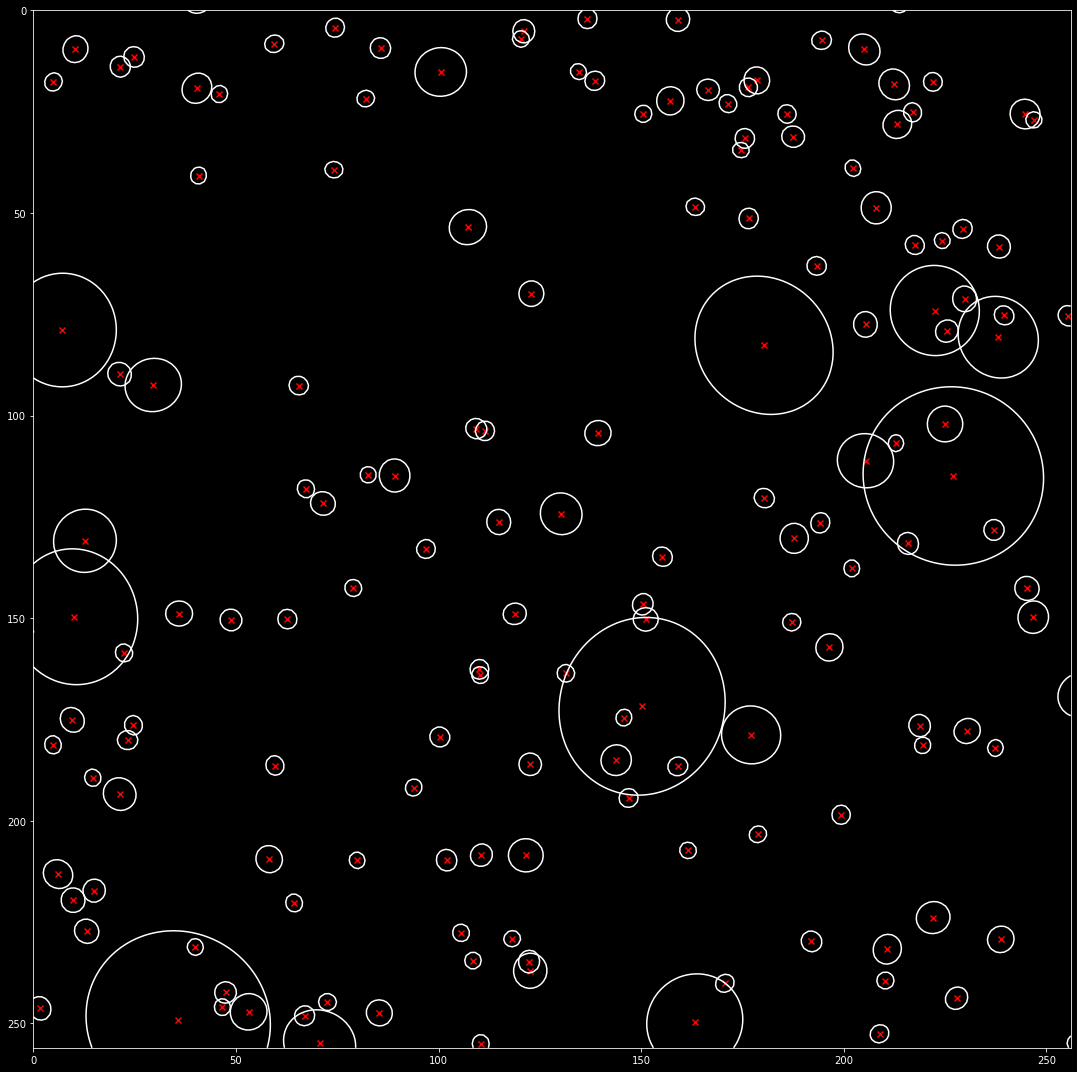

In [5]:
plt.style.use('dark_background')
x_plot = np.linspace(0, cam.resolution[0], 250)
y_plot = np.linspace(0, cam.resolution[1], 250)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.set_xlim(0, cam.resolution[0])
ax.set_ylim(cam.resolution[1], 0)

for a_i in A_craters:
    c = xy_homogeneous.transpose(0, 2, 1) @ scale_det(a_i) @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors='w')
ax.scatter(*(LA.inv(A_craters[:, :2, :2]) @ -A_craters[:, :2, 2][..., None])[..., 0].T, c='r', marker='x')
# ax.set_axis_off()
fig.tight_layout()

In [ ]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv")

In [13]:
max_iter = 20
for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters)):
    print("Crater triad coords: ", lat_cat[vicinity][crater_triad], long_cat[vicinity][crater_triad])
    p = features.get_pattern()
    print("Detection feature: ", p)
    match = np.argmin(np.mean(np.abs((p - db.features)/p), axis=1))
    print("DB match feature: ", db.features[match])
    print("DB match coords: ", *db.get_position(match))
    print()

    if i >= max_iter:
        break


Crater triad coords:  [0.95664289 0.87941032 0.8851734 ] [0.83461121 0.86682999 0.811524  ]
Detection feature:  [ -26.12321722  -22.17378668   -3.60718296   -5.24748154  -22.65242412
  -32.13437115 -133.05200313]
DB match feature:  [ -19.64735967  -20.72165173   -3.7054866    -6.20198535  -24.22289631
  -42.22131535 -131.4269315 ]
DB match coords:  [1.30508042 1.30640862 1.32247612] [1.32322137 1.47958542 1.343167  ]

Crater triad coords:  [0.89323508 0.9017453  0.84997011] [0.91119626 0.89114243 0.54770701]
Detection feature:  [  -10.92841595   -11.62829215 -2431.22785557 -1273.08617352
 -2208.39419656 -1113.22605312 -9351.70174188]
DB match feature:  [  -11.91873598   -11.32059125 -1969.38745085 -1362.81801014
 -1703.35354868 -1179.88081091 -7361.3896392 ]
DB match coords:  [1.20092266 1.19327986 1.08983594] [2.90068486 2.88649533 2.96723426]

Crater triad coords:  [0.81800266 0.81087823 0.74868342] [0.5770617  0.68562467 0.59127915]
Detection feature:  [ -98.39969907 -114.99844166 -